# Lessons from the Machine Learning Hackathon

## Introduction


## Overview
- Introduction
- AI at Dell (AI COE)
- The Hackathon
- Algorithms Introduction
- Common Challenges
    - NLP Pre-processing/Feature Engineering
- Their approach
- Our approach
- Q & A

## AI at Dell
- AI COE
- Purpose
- Teams
- Resources
- website

## Hackathon
- The Problem
- The Resources
- Teams and Regions

## Algorithms Introduction

### Neural Networks
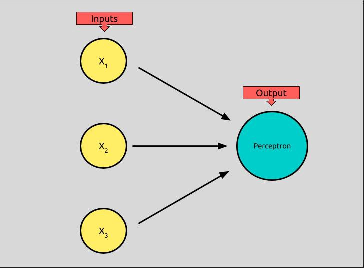
- Architectures

- Back-propation

### Genetic Algorithm


## Common Challenges
- Pre-Pre-processing
-- How large is the data set (1.6 million rows?)
-- Is it "balanced"; Positive versus Neutral versus other categories;  Random under and over sampling or Stratification


- Pre-Processing	
1. NLTK Stop Work Removal
2. Removing Punctuations
3. Common Words Removal
4. Rare Words Removal
5. Spell Correction
6. Stemming
7. Lemmatization	
8. POS Tagging
9. Name-Entity Recognition

•	Tokenization — convert sentences to words
•	Removing unnecessary punctuation, tags, special charcters
•	Removing stop words — frequent words such as ”the”, ”is”, etc. that do not have specific semantic meaning
*   Removing common words -- "hard drive" in Storage Product reviews
*   Spelling correction
•	Top 50 words in db

![WordCloud]("img/wordcloud1.img")
![top50wordsBefore](img/top50palabsdirty.png)
![top50wordsBefore](img/top50palabsclean.png)

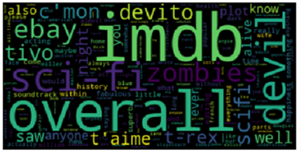
•	Stemming — words are reduced to a root by removing inflection through dropping unnecessary characters, usually a suffix.
•	Lemmatization — Another approach to remove inflection by determining the part of speech and utilizing detailed database of the language.
The stemmed form of studies is: studi
The stemmed form of studying is: study
The lemmatized form of studies is: study
The lemmatized form of studying is: study




- Feature Engineering	
1. Re-Sampling for Class Balancing
1. Domain features with TF-IDF
2. N-Gram Bag of Words
3. TF-IDF Word Features	
4. Word Embeddings
Replace words with numbers:
1. Bag of Words (BOW)
2. TF-IDF
In text processing, words of the text represent discrete, categorical features. How do we encode such data in a way which is ready to be used by the algorithms? The mapping from textual data to real valued vectors is called feature extraction. One of the simplest techniques to numerically represent text is Bag of Words
BOW - list of unique words, and represent each sentence/doc as vector


- Modeling Techniques	
1. Logistic Regression 
2. Naïve Bayes
3. Random Forest
4. LDA
5. SVM
6. XGBoost
7. Neural Networks (RNN-LSTM)
 - Calculate Loss: MSE
 - Write as multivariable function
     - This system of calculating partial derivatives by working backwards is known as backpropagation, or “backprop”.
 - Train 
Before we train our network, we first need a way to quantify how “good” it’s doing so that it can try to do “better”. That’s what the loss is.
We’ll use the mean squared error (MSE) loss:
We now have a clear goal: minimize the loss of the neural network. We know we can change the network’s weights and biases to influence its predictions, but how do we do so in a way that decreases loss?

- Resource Limitations
1. Memory
2. Processing (GPU Acceleration)



In [1]:
########################################
## import packages
########################################
from __future__ import print_function
import neat
import visualize
import os
import re
import csv
import sys
from datetime import datetime
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten, Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.layers import Bidirectional, GlobalMaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D ,Conv1D, MaxPooling1D, GRU,CuDNNLSTM,CuDNNGRU, Reshape, MaxPooling1D,AveragePooling1D
from keras.optimizers import RMSprop, SGD
from keras.utils import to_categorical

import colorama
from colorama import Fore


from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

########################################
## set directories and parameters
########################################


from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints

Using TensorFlow backend.


In [10]:
# Program Parameters
TRAIN_DATA_FILE = "train.csv"
ga_config = "ga_config.txt" # Parameters for the genetic algorithm
max_features = 250000 # Maximum Number of Words in Dictionary
maxlen = 300   # Maximum Sequence Size

# Genetic Algorithm Hyperparameters
max_generations = 100 # previously 300
limit = 100000 # limit number of rows to train per network
# Note: limit must match fitness_threshold in ga_config

In [3]:
# Load Files
print ("Loading Data from " + str(TRAIN_DATA_FILE))
final_validation_file = pd.read_csv(TRAIN_DATA_FILE)[:176230]  # (176230)
print(".")
test_df = pd.read_csv(TRAIN_DATA_FILE)[176231:511230] # (335000)
print(".")
train_df = pd.read_csv(TRAIN_DATA_FILE)[511231:1672297]
print("done!")
total_rows = len(train_df.index)


Loading Data from train.csv
.
.
done!


In [4]:
# Data preview
print(train_df.head())
print("Total rows: ", total_rows)

                                               ReviewText  Rating
511231  Only had it for 2 weeks, but so far it seems f...       4
511232  Great to deal with this company.  Turned out m...       5
511233  It does the job for a very low price what more...       5
511234  My brother will be very happy, I gave him my H...       5
511235  I do not subject my battery to a lot of wear a...       2
Total rows:  1161066


In [5]:
print("Prepare Data ")
print(".")
list_sentences_train = train_df["ReviewText"].fillna("NA").values
list_classes = ["negative", "somewhat negative", "neutral", "somewhat positive", "positive"]
num_classes=5
print(".")
#y = train_df[list_classes].values
target=train_df['Rating'].values
y1=to_categorical(target)
y=np.delete(y1, 0, axis=1)
print(".")
list_sentences_test = test_df["ReviewText"].fillna("NA").values
yaux=y[:,[0]]
print("done!")


Prepare Data 
.
.
.
done!


## Feature Engineering
- ngrams
- other

In [6]:
# Split training sentences into arrays of words 

comments = []
for text in list_sentences_train:
    comments.append(text)
    

In [7]:
# Split test sentences into arrays of words 

test_comments=[]
for text in list_sentences_test:
    test_comments.append(text)

In [8]:
print("Create an index and summary of words in word arrays")
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(comments + test_comments)

print("Convert arrays of words into bag-of-word arrays")
sequences = tokenizer.texts_to_sequences(comments)
test_sequences = tokenizer.texts_to_sequences(test_comments)


Create an index and summary of words in word arrays
Convert arrays of words into bag-of-word arrays


In [ ]:
print("Print a summary of data")
print(len(sequences), 'train sequences')
print(len(test_sequences), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, sequences)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, test_sequences)), dtype=int)))
print(len(sequences), 'train sequences')
print(len(test_sequences), 'test sequences')
print('Max train sequence length: {}'.format(np.max(list(map(len, sequences)))))
print('Max test sequence length: {}'.format(np.max(list(map(len, test_sequences)))))
print(len(sequences), 'train sequences')
print(len(test_sequences), 'test sequences')
print('Min train sequence length: {}'.format(np.min(list(map(len, sequences)))))
print('Min test sequence length: {}'.format(np.min(list(map(len, test_sequences)))))

Print a summary of data
1161066 train sequences
334999 test sequences
Average train sequence length: 119
Average test sequence length: 118
1161066 train sequences
334999 test sequences
Max train sequence length: 6344
Max test sequence length: 5626
1161066 train sequences
334999 test sequences
Min train sequence length: 0
Min test sequence length: 0


In [ ]:
# Name word index
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

# Format data so that it'll fit into the neural network
data = pad_sequences(sequences, maxlen=maxlen)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=maxlen)
print('Shape of test_data tensor:', test_data.shape)

Found 508584 unique tokens
Shape of data tensor: (1161066, 300)
Shape of label tensor: (1161066, 5)
Shape of test_data tensor: (334999, 300)


In [ ]:
print("Example conversion of text to padded Sequence:")
print(comments[0])
print(data[0])

Example conversion of text to padded Sequence:
Only had it for 2 weeks, but so far it seems functional. While editing photos (pushing the computer hard) the battery lasts 2.5'ish hours.Placed it in a Dv6 1030 laptop.
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
  

In [11]:
## Their Approach
- Models

NameError: name 'Models' is not defined

## Our Approach
- NEAT
- Comparison to traditional methods

In [ ]:
# Defines the fitness function for a genome as the accuracy of its neural network
# Evaluates the fitness by building and testing the evolved neural network
def category_match(calculated, correct):
    rounded = list(map(round, calculated))
    matches = 0
    for category in range(0,len(correct)):
        if rounded[category] == correct[category]:
            matches += 1
    return matches/(len(correct)-1)
    
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0 # default fitness (should be very bad)
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        count = 0
        matches = 0
        for xi, xo in zip(data[:limit], y[:limit]):
            output = net.activate(xi)
            count += 1
            matches += category_match(output, xo)
        # The fittest individual has the most correct categorizations
        genome.fitness = matches/count


In [ ]:
# Runs the genetic algorithm
def run_ga(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, max_generations)

    # Display the winning genome (Very ugly)
#     print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    #     @TODO: Replace with validation set here
    print('\nMost fit individual performance:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(data[:limit], y[:limit]):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

#     visualize.draw_net(config, winner, True)
#     visualize.plot_stats(stats, ylog=False, view=True)
#     visualize.plot_species(stats, view=True)

#     p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    p.run(eval_genomes, 10)

In [ ]:
print("max_generations",max_generations)
run_ga(ga_config)

max_generations 100

 ****** Running generation 0 ****** 

Population's average fitness: 0.62202 stdev: 0.03898
Best fitness: 0.70096 - size: (5, 1500) - species 1 - id 30
Average adjusted fitness: 0.073
Mean genetic distance 1.203, standard deviation 0.173
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50      0.7    0.073     0
Total extinctions: 0
Generation time: 13666.573 sec
Saving checkpoint to neat-checkpoint-0

 ****** Running generation 1 ****** 

Population's average fitness: 0.66702 stdev: 0.02984
Best fitness: 0.73495 - size: (5, 1495) - species 1 - id 62
Average adjusted fitness: 0.100
Mean genetic distance 1.264, standard deviation 0.190
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50      0.7    0.100     0
Total extinctions: 0
Generation time: 13696.097 sec (13681.335 average)
Saving chec

## Q & A